In [2]:
# Required libraries
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# data load
fashion_mnist = keras.datasets.fashion_mnist

# define training dataset and test dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [15]:
# define labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print('class length: ',len(class_names))

class length:  10


In [14]:
print('** data size of Fasion_MNIST **\n')
print('x_train: ',train_images.shape)
print('y_train: ',train_labels.shape)
print('x_test: ',test_images.shape)
print('y_test: ',test_labels.shape)

** data size of Fasion_MNIST **

* x_train:  (60000, 28, 28)
* y_train:  (60000,)
* x_test:  (10000, 28, 28)
* y_test:  (10000,)


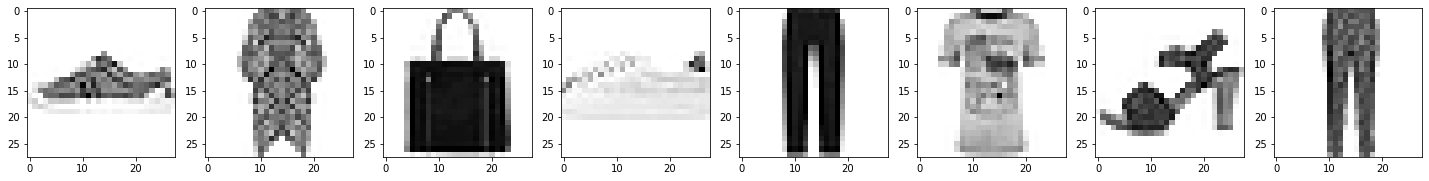

In [26]:
# see some images (28x28 size input, pixel: 0~255)
plt.figure(figsize = (25,15))
for i in range(8):
  plt.subplot(int('18'+str(i+1)))
  plt.imshow(train_images[np.random.randint(10000),:,:],cmap = plt.cm.binary)
plt.show()

In [23]:
# preprocessing (0~255 -> 0~1)
train_images = train_images / 255.0
test_images = test_images / 255.0

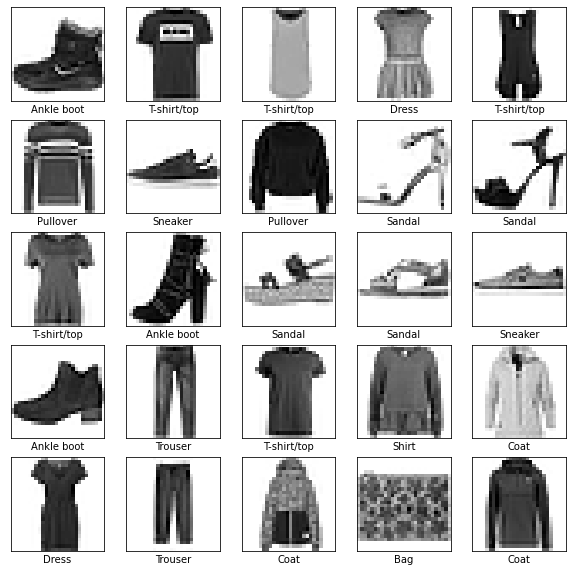

In [24]:
# check the labels corresponding to images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]]) # index 0 ~ 24 images
plt.show()

In [27]:
# apply batch & shuffle
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size = 10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

In [33]:
# model construction
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__() 
        self.flatten = tf.keras.layers.Flatten(input_shape = (28,28))
        self.d1 = tf.keras.layers.Dense(128,activation = 'relu')
        self.d2 =  tf.keras.layers.Dense(10,activation = 'softmax')
 
    def call(self, x):
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

In [34]:
model = MyModel()

In [39]:
# choose the loss function and optimizer as 'default'
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# representations
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [40]:
# model training function
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions) 
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
 
    train_loss(loss)
    train_accuracy(labels, predictions)

# model test function
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
 
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [41]:
EPOCHS = 5
 
TRLO = []
TRA = []
TSLO = []
TSA = []
 
# model learning process
for epoch in range(EPOCHS):
    for images, labels in train_ds: # for the images and labels in our dataset
        train_step(images, labels) # training the model
 
    for test_images, test_labels in test_ds: # if the training process is done,
        test_step(test_images, test_labels) # testing the model (model prediction)

    template = '에포크: {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
    print (template.format(epoch+1,
                                    train_loss.result(),
                                    train_accuracy.result()*100,
                                    test_loss.result(),
                                    test_accuracy.result()*100))
 
    TRLO.append(train_loss.result())
    TRA.append(train_accuracy.result()*100)
    TSLO.append(test_loss.result())
    TSA.append(test_accuracy.result()*100)

에포크: 1, 손실: 0.49778905510902405, 정확도: 82.34666442871094, 테스트 손실: 0.4310208559036255, 테스트 정확도: 84.48999786376953
에포크: 2, 손실: 0.4372978210449219, 정확도: 84.36750030517578, 테스트 손실: 0.4128890931606293, 테스트 정확도: 85.2199935913086
에포크: 3, 손실: 0.403489887714386, 정확도: 85.47444152832031, 테스트 손실: 0.39784395694732666, 테스트 정확도: 85.67333221435547
에포크: 4, 손실: 0.38078147172927856, 정확도: 86.21875, 테스트 손실: 0.3965861201286316, 테스트 정확도: 85.65250396728516
에포크: 5, 손실: 0.3634463846683502, 정확도: 86.80699920654297, 테스트 손실: 0.38797619938850403, 테스트 정확도: 85.96600341796875


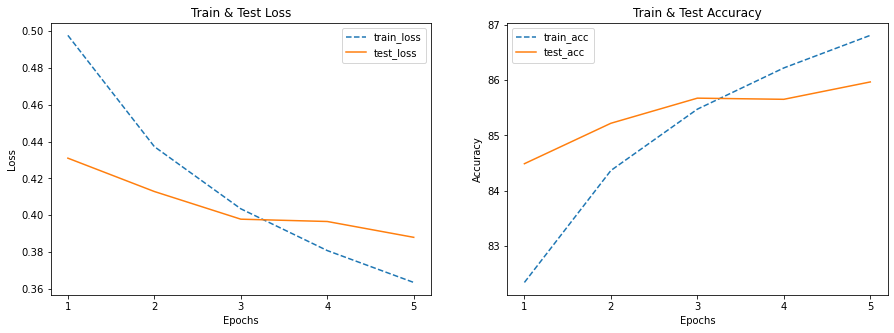

In [42]:
## occur 'overfitting' over epoch 3
E = list(range(1,EPOCHS+1))

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.plot(E,TRLO,'--',label = 'train_loss')
plt.plot(E,TSLO,label = 'test_loss')
plt.xticks(E)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Test Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(E,TRA,'--',label = 'train_acc')
plt.plot(E,TSA,label = 'test_acc')
plt.xticks(E)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train & Test Accuracy')
plt.legend()
plt.show()

In [51]:
def get_digit(layer_output): # this is the same as np.argmax()
    pred = [] # list for containing 'digit'

    for i in range(len(layer_output)):
        max_val = 0 # the maximum of 10 probabilities
        ind = [] # the index of the maximum
        for j in range(len(layer_output[i])):
            if max_val < layer_output[i,j]: # criterion
                max_val = layer_output[i,j] # update
                ind.append(j) # save the index of each max_val

        pred.append(ind[-1]) # save the final max_val
    pred = np.array(pred) # convert the data type
    return pred

In [52]:
output = model.call(test_images).numpy()

print('** label: \n',test_labels.numpy())
print('\n** prediction: \n',get_digit(output))

** label: 
 [3 2 7 5 8 4 5 6 8 9 1 9 1 8 1 5]

** prediction: 
 [3 1 7 5 8 4 5 6 8 9 1 9 1 8 1 5]


In [166]:
p = get_digit(output)

prediction = []
trues = []

for i in p:
    prediction.append(class_names[i])

for j in test_labels:
    trues.append(class_names[j])

In [167]:
print('** label: \n',trues)
print('\n** prediction: \n',prediction)

** label: 
 ['Dress', 'Pullover', 'Sneaker', 'Sandal', 'Bag', 'Coat', 'Sandal', 'Shirt', 'Bag', 'Ankle boot', 'Trouser', 'Ankle boot', 'Trouser', 'Bag', 'Trouser', 'Sandal']

** prediction: 
 ['Dress', 'Trouser', 'Sneaker', 'Sandal', 'Bag', 'Coat', 'Sandal', 'Shirt', 'Bag', 'Ankle boot', 'Trouser', 'Ankle boot', 'Trouser', 'Bag', 'Trouser', 'Sandal']


In [163]:
def result_bar(i,prediction,true_label):
    prediction, true_label = prediction[i], true_label[i]
    
    pred_bar = plt.bar(class_names,prediction,color = 'gray')
    plt.xticks(rotation = 45)
    plt.yticks([])
    plt.ylim([0, 1])
    plt.grid(False)
    
    prediction_label = np.argmax(prediction)
    
    if prediction_label == true_label:
        pred_bar[prediction_label].set_color('blue')
        pred_bar[prediction_label].set_label('Prediction = True')
    else:
        pred_bar[prediction_label].set_color('red')
        pred_bar[prediction_label].set_label('Prediction')
        pred_bar[true_label].set_color('blue')
        pred_bar[true_label].set_label('True')
        
    plt.legend()
    
def result_image(i,prediction,true_label,images):
    prediction, true_label, img = prediction[i], true_label[i], images[i]

    prediction_label = np.argmax(prediction)
    
    if prediction_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    imgplot = plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel('{} {:2.0f}% ({})'.format(class_names[prediction_label],
                                         100*np.max(prediction),
                                         class_names[true_label]),color = color,fontsize = 20)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

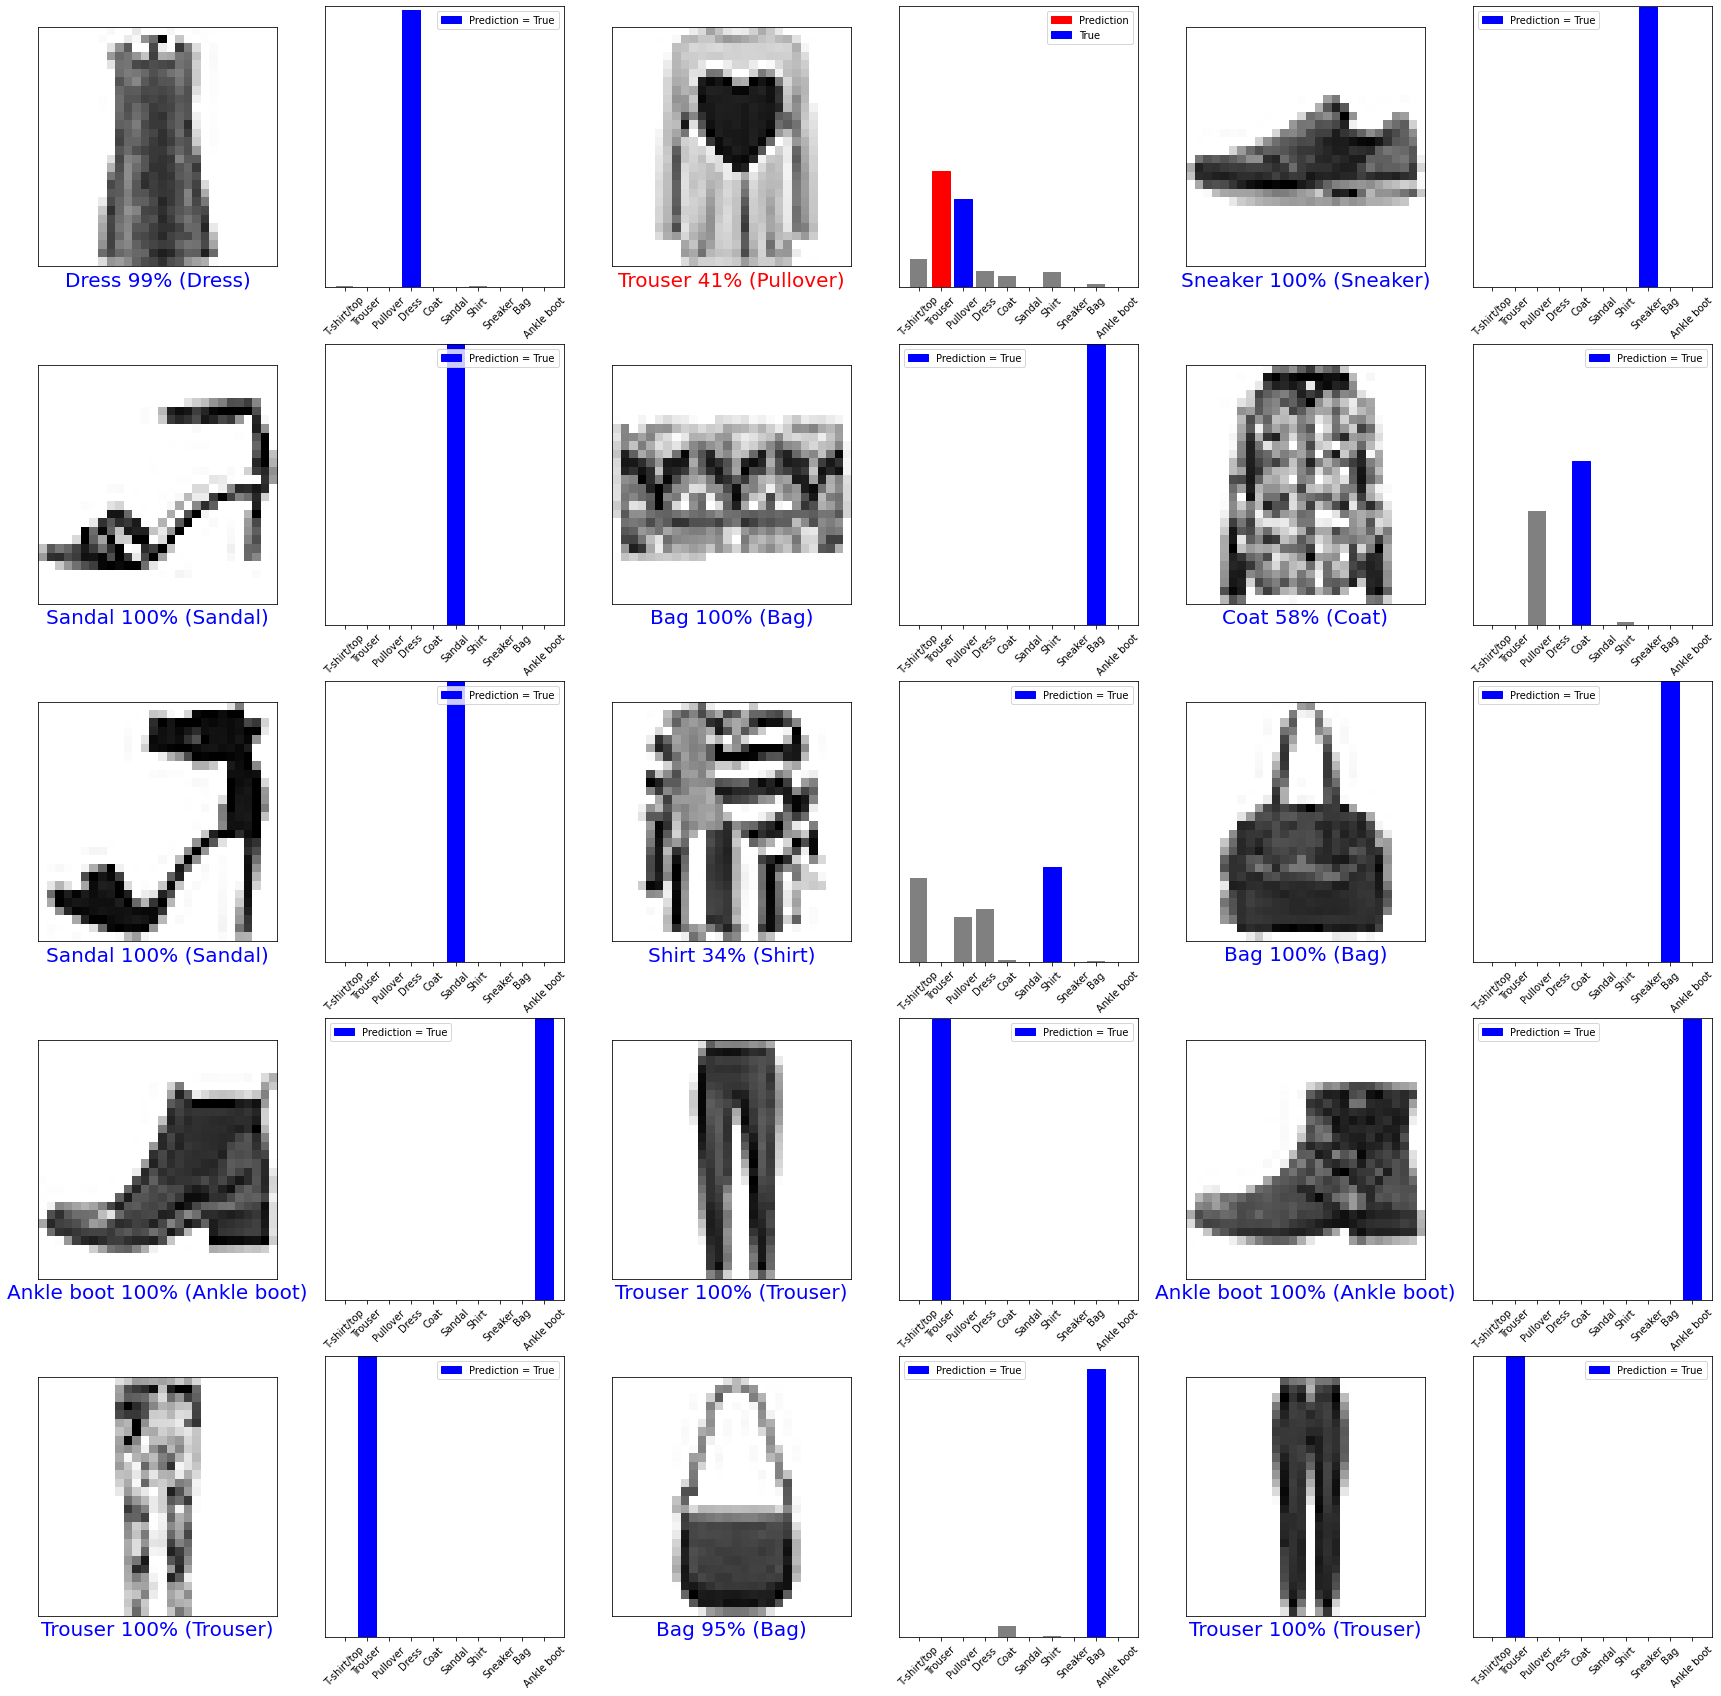

In [164]:
plt.figure(figsize = (30,30))
for i in range(len(test_labels)-1):
    plt.subplot(5,6,2*i+1)
    result_image(i,output,test_labels,test_images)
    plt.subplot(5,6,2*i+2)
    result_bar(i,output,test_labels)